<a href="https://colab.research.google.com/github/VG1234/NLP_PROJECT/blob/main/NLP_TEAM5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **<font color="#cf8b0f">Natural Language Processing Course Project</font>**



> Naimisha Pinna (*npinn001@odu.edu*)

> Venugopal Nagandla (*vnaga002@odu.edu*)








## Abstract
---
People could find it challenging to open the link associated to the incomplete question tweet and thoroughly read and understand it because of the abundance of information and tweets that are now available on the Twitter site. Therefore, we examine the issue of question identification on tweets that are available on Twitter in this research and respond to the incomplete tweets. We would get an answer for them and a quick overview of the information given in the URLs attached to the incomplete question tweets. There are three steps in it: Finding and removing tweets that contain questions; obtaining the tweet's description from the URL specified in the tweet; and obtaining the tweet's responses from the web source in the URL.

We examine 3000 tweets in total for the study. Making API calls to the Twitter platform yields the tweet dataset. We would also compare the effectiveness of several classifiers used for question detection.

## Introduction
---

Twitter is more widely used than any other social media network because of the information it spreads. When dealing with social media platforms like Twitter, where information is flooded with rich content and is always growing, the significance of summary becomes even more crucial. In addition to adopting this kind of communication to maintain relationships, many individuals also utilize it as a reliable source of information and participate in question-and-answer sessions (Q and A). As social Q&A becomes more and more popular, many queries are being posed on Twitter, some of which are of an objective nature and are accompanied by links to articles or other online sources. The description and solutions are available at this page.

The goal of this project is to find objective, incomplete question tweets with a URL offered as an answer. From there, we will obtain a quick summary utilizing the information from the URL's web source or article. Many Twitter users would benefit from this saving of time. There is academic study that focuses on Twitter question identification. By obtaining the answers to the question, our work in this project extends the Question Identification.




In [ ]:
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time
#Installing selenium to web scrap the information from the url link
!apt update
!apt install chromium-chromedriver
!pip install selenium
!pip install transformers


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://security.ubuntu.c

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 15.0 MB/s 
     |████████████████████████████████| 182 kB 74.1 MB/s 
     |████████████████████████████████| 7.6 MB 278 kB/s 
     |████████████████████████████████| 127 kB 43.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.13
    Uninstalling urllib3-1.26.13:
      Successfully uninstalled urllib3-1.26.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.7.2 requires urllib3[socks]~=1.26, but you have urllib3 1.25.11 which is incompatible.


## Twitter API 
---
We have used Twitter API to retirive all the tweets of four different twitter pages


In [ ]:
os.environ['TOKEN'] = 'AAAAAAAAAAAAAAAAAAAAAAq9jQEAAAAAwnZ%2BRfR5T7y15H%2FCcJSkIy0q2Ps%3DCmMg1XbTxKq6oS03TqVfhdLKNmPg9QLtGFJ9hFgtqAydKZWUcO';

In [ ]:
def auth():
    return os.getenv('TOKEN')

In [ ]:
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

In [ ]:
def create_url( accountid,max_results = 10):
    
    search_url = "https://api.twitter.com/2/users/"+accountid+"/tweets" #Change to the endpoint you want to collect data from

    #change params based on the endpoint you are using
    query_params = {
                    'max_results': max_results,
                    'tweet.fields': 'id,text,author_id,lang,entities',
                    'next_token': {}}
    return (search_url, query_params)

In [ ]:
def connect_to_endpoint(url, headers, params, next_token = None):
    params['pagination_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [ ]:
#Inputs for the request
bearer_token = auth()
headers = create_headers(bearer_token)
max_results = 50

In [ ]:
def append_to_csv(json_response, fileName):

    #A counter variable
    counter = 0

    #Open OR create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in json_response['data']:
        
        # We will create a variable for each since some of the keys might not exist for some tweets
        # So we will account for that

        # 1. Author ID
        author_id = tweet['author_id']

       
        # 4. Tweet ID
        tweet_id = tweet['id']

        # 5. Language
        lang = tweet['lang']

        
        # 8. Tweet text
        text = tweet['text']
        if 'urls' in tweet['entities']:
          url=tweet['entities'].get('urls')[0].get('url')
        else: 
          url=''
        print(url);
        # Assemble all data in a list
        res = [id,text,author_id,lang,url]
        
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1
    csvFile.close()


In [ ]:
#Inputs for tweets
bearer_token = auth()
headers = create_headers(bearer_token)

max_results = 99
#Total number of tweets we collected from the loop
total_tweets = 0

# Create file
csvFile = open("twitterdata.csv", "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

#Create headers for the data you want to save, in this example, we only want save these columns in our dataset
csvWriter.writerow(['id','text','authorid','lang','url'])
csvFile.close()
accounts=['1520115242134642690','4069075997','587714983'];
for i in range(0,3):
  if total_tweets>3000:
    break;
  # Inputs
  count = 0 # Counting tweets per time period
  max_count = 1000 # Max tweets per time period
  flag = True
  next_token = None

  # Check if flag is true
  while flag:
    # Check if max_count reached
    if count >= max_count:
        break
    print("-------------------")
    print("Token: ", next_token)
    url = create_url( accounts[i],max_results)
    print(url)
    json_response = connect_to_endpoint(url[0], headers, url[1], next_token)
    result_count = json_response['meta']['result_count']

    if 'next_token' in json_response['meta']:
        # Save the token to use for next call
        next_token = json_response['meta']['next_token']
        print("Next Token: ", next_token)
        print(result_count)
        print(next_token)
        if result_count is not None and result_count > 0 and next_token is not None:
            #print("Start Date: ", start_list[i])
            print('I am here in if')
            append_to_csv(json_response, "twitterdata.csv")
            count += result_count
            total_tweets += result_count
            print("Total # of Tweets added: ", total_tweets)
            print("-------------------")
            time.sleep(5)                
    # If no next token exists
    else:
        if result_count is not None and result_count > 0:
            print("-------------------")
            #print("Start Date: ", start_list[i])
            append_to_csv(json_response, "twitterdata.csv")
            count += result_count
            total_tweets += result_count
            print("Total # of Tweets added: ", total_tweets)
            print("-------------------")
            time.sleep(5)
        
        #Since this is the final request, turn flag to false to move to the next time period.
        flag = False
        next_token = None
    time.sleep(5)
print("Total number of results: ", total_tweets)

-------------------
Token:  None
('https://api.twitter.com/2/users/1520115242134642690/tweets', {'max_results': 99, 'tweet.fields': 'id,text,author_id,lang,entities', 'next_token': {}})
Endpoint Response Code: 200
Next Token:  7140dibdnow9c7btw424c2869idvnfc4xys2lru2x0rw0
99
7140dibdnow9c7btw424c2869idvnfc4xys2lru2x0rw0
I am here in if
https://t.co/nFZCEvASSF

https://t.co/DIuDfjuIJq
https://t.co/t9IOAcLrLv

https://t.co/IH82n2eNK2
https://t.co/PCmQWfy0mo
https://t.co/TEXJgUitmZ

https://t.co/MvneZCrMAe
https://t.co/ZpQFPCTv9Q
https://t.co/argJf4U2XC
https://t.co/heNtPL2Asz

https://t.co/K2LikwAHaz
https://t.co/XB7IKiQL4u

https://t.co/cFvsAsArYx
https://t.co/eFnwf8HkQk

https://t.co/H8SVETS50N

https://t.co/dJ7AVSTVKE
https://t.co/vvL73TrSvH
https://t.co/1bEuHMThfh
https://t.co/sroQjPr5Fb
https://t.co/D3URUg8z9q

https://t.co/ADpapTTVwB
https://t.co/vz97Ybe6ms
https://t.co/sS66xcH4Q3
https://t.co/QR408N2JEx
https://t.co/QecNYPFum9
https://t.co/j9Yb4NGD2E
https://t.co/SNPPT8n59m
https:

## Naive Bayes Classifier

> This block of code is used to identify whether a tweet is a question or not from the above dataset
> We have not used this dataset, as recommended by the professor.




In [ ]:
import nltk.corpus
#from nltk.corpus import nps_chat
nltk.download('nps_chat')
nltk.download('punkt')
from nltk.tokenize import TweetTokenizer
 
class QuestionDetector():
 
    #Class Initialier:
    #- Creates naive bayes classifier using nltk nps_chat corpus.
    #- Initializes Tweet tokenizer
    #- Initializes question words set to be used
    def __init__(self):
        posts = nltk.corpus.nps_chat.xml_posts()
        featuresets = [(self.__dialogue_act_features(post.text), post.get('class')) for post in posts]
        print(featuresets)
        size = int(len(featuresets) * 0.1)
        train_set, test_set = featuresets[size:], featuresets[:size]
        self.classifier = nltk.NaiveBayesClassifier.train(train_set)
        Question_Words = ['what', 'where', 'when','how','why','did','do','does','have','has','am','is','are','can','could','may','would','will','should'
"didn't","doesn't","haven't","isn't","aren't","can't","couldn't","wouldn't","won't","shouldn't",'?']
        self.Question_Words_Set = set(Question_Words)
        self.tknzr = TweetTokenizer()
    #Private method, Gets the word vector from sentance
    def __dialogue_act_features(self,sentence):
         features = {}
         for word in nltk.word_tokenize(sentence):
             features['contains({})'.format(word.lower())] = True
         return features
    #Public Method, Returns 'True' if sentance is predicted to be a question, returns 'False' otherwise
    def IsQuestion(self,sentence):
        if "?" in sentence:
            return True
        tokens = self.tknzr.tokenize(sentence.lower())
        if self.Question_Words_Set.intersection(tokens) == False:
            return False
        predicted = self.classifier.classify(self.__dialogue_act_features(sentence))
        if predicted == 'whQuestion' or predicted == 'ynQuestion':
            return True
         
        return False
    

[nltk_data] Downloading package nps_chat to /root/nltk_data...
[nltk_data]   Unzipping corpora/nps_chat.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# import pandas module 
import pandas as pd 
import numpy as np
# making dataframe 
df = pd.read_csv("DatasetforNC.csv") 
# output the dataframe
#print(df)
'''tx=QuestionDetector();
print(tx.IsQuestion('How are you doing'))'''
#foo = lambda x = Foo(): (x.parse("All set"), x)[-1]

#Add new column as question to check if the text of a tweet is a question
df['question'] = df['text'].apply(lambda t,x= QuestionDetector(): x.IsQuestion(t))
#print(df)

#Filter the dataframe to get only those rows where the text in tweet is a question
#dfquestion = df[df['question'] == True] 

#print(dfquestion)
df.drop('id',inplace=True,axis=1)
df.drop('authorid',inplace=True,axis=1)
df.drop('lang',inplace=True,axis=1)
df.drop('url',inplace=True,axis=1)
df.rename(columns = {'question':'label'}, inplace = True)
columns_titles = ["label","text"]
df=df.reindex(columns=columns_titles);
df['label'] = df['label'].replace([False],0)
df['label'] = df['label'].replace([True],1)
print(df);
df.to_csv('DatasetforBertClassifier.csv');



[({'contains(now)': True, 'contains(im)': True, 'contains(left)': True, 'contains(with)': True, 'contains(this)': True, 'contains(gay)': True, 'contains(name)': True}, 'Statement'), ({'contains(:)': True, 'contains(p)': True}, 'Emotion'), ({'contains(part)': True}, 'System'), ({'contains(hey)': True, 'contains(everyone)': True}, 'Greet'), ({'contains(ah)': True, 'contains(well)': True}, 'Statement'), ({'contains(nick)': True, 'contains(:10-19-20suser7)': True}, 'System'), ({'contains(10-19-20suser7)': True, 'contains(is)': True, 'contains(a)': True, 'contains(gay)': True, 'contains(name)': True, 'contains(.)': True}, 'Accept'), ({'contains(.action)': True, 'contains(gives)': True, 'contains(10-19-20suser121)': True, 'contains(a)': True, 'contains(golf)': True, 'contains(clap)': True, 'contains(.)': True}, 'System'), ({'contains(:)': True, 'contains())': True}, 'Emotion'), ({'contains(join)': True}, 'System'), ({'contains(hi)': True, 'contains(10-19-20suser59)': True}, 'Greet'), ({'cont

## BERT fine tuning


> BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.

> In this post, we will come across each word's meaning as we come across it. Now, the most important thing to remember from this paragraph is that BERT is built on the Transformer design. Second, the entirety of Wikipedia (2,500,000,000 words!) and the Book Corpus comprise a sizable corpus of unlabeled text that BERT is pre-trained on (800 million words).

> The success of BERT is partially due to this pre-training phase. This is due to the fact that as a model is trained on a huge text corpus, it begins to comprehend the language more deeply and specifically. This information serves as the swiss army knife for nearly all NLP tasks.


> Below block of code is used to fine tune the dataset (contains 100 records of tweets which are labeled manually as 1 and 0) to check whether a tweet is complete question or incomplete question and classifying them with integer values:

*   1 represent as True
*   0 represent as False





In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [ ]:
import pandas as pd
df = pd.read_csv("Datasetforbert.csv")
df.head()

,label,text
0,0,Scientists have discovered a new dinosaur. It ...
1,1,RT @DarkMatterPosts: How was coal formed? This...
2,0,"50,000-Year-Old Zombie Virus Found in Permafro..."
3,1,RT @DarkMatterPosts: The world’s strangest foo...
4,1,RT @DarkEnergyTweet: Dachshund bones were foun...


In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

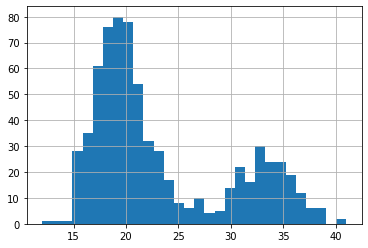

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased',return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )
class_weights = dict(zip(np.unique(train_labels), class_weights))


print("Class Weights:",class_weights)

li=list(class_weights.values())
print(li)

Class Weights: {0: 0.948509485094851, 1: 1.0574018126888218}
[0.948509485094851, 1.0574018126888218]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(li,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds


In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 10

Evaluating...

Training Loss: 0.701
Validation Loss: 0.692

 Epoch 2 / 10

Evaluating...

Training Loss: 0.693
Validation Loss: 0.690

 Epoch 3 / 10

Evaluating...

Training Loss: 0.690
Validation Loss: 0.688

 Epoch 4 / 10

Evaluating...

Training Loss: 0.688
Validation Loss: 0.687

 Epoch 5 / 10

Evaluating...

Training Loss: 0.686
Validation Loss: 0.685

 Epoch 6 / 10

Evaluating...

Training Loss: 0.686
Validation Loss: 0.684

 Epoch 7 / 10

Evaluating...

Training Loss: 0.683
Validation Loss: 0.683

 Epoch 8 / 10

Evaluating...

Training Loss: 0.685
Validation Loss: 0.682

 Epoch 9 / 10

Evaluating...

Training Loss: 0.681
Validation Loss: 0.681

 Epoch 10 / 10

Evaluating...

Training Loss: 0.683
Validation Loss: 0.680


In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>



###Predictions for data



In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
  print(preds)

[[-0.76443356 -0.6266062 ]
 [-0.62908936 -0.7615912 ]
 [-0.64985096 -0.7384033 ]
 [-0.6548755  -0.7329421 ]
 [-0.7093935  -0.67716074]
 [-0.67907345 -0.7074217 ]
 [-0.635772   -0.75401586]
 [-0.679223   -0.70726806]
 [-0.71809417 -0.6688073 ]
 [-0.76899016 -0.62265307]
 [-0.7742483  -0.61813295]
 [-0.75687337 -0.63324004]
 [-0.7109028  -0.67570126]
 [-0.7094747  -0.6770821 ]
 [-0.6935526  -0.69274193]
 [-0.68036467 -0.7060951 ]
 [-0.712506   -0.6741561 ]
 [-0.5974831  -0.7989404 ]
 [-0.62830913 -0.7624824 ]
 [-0.66578376 -0.7212804 ]
 [-0.76340836 -0.6275001 ]
 [-0.5996969  -0.79623914]
 [-0.6326871  -0.7574993 ]
 [-0.6296973  -0.7608974 ]
 [-0.61534953 -0.77751184]
 [-0.632534   -0.7576728 ]
 [-0.7244469  -0.66279745]
 [-0.6940104  -0.6922847 ]
 [-0.66639    -0.72064   ]
 [-0.7368602  -0.6512653 ]
 [-0.69092625 -0.6953731 ]
 [-0.6757853  -0.7108159 ]
 [-0.6935526  -0.69274193]
 [-0.7866044  -0.6076825 ]
 [-0.6756748  -0.7109302 ]
 [-0.6739339  -0.7127369 ]
 [-0.6202593  -0.77176845]
 

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.63      0.72      0.67        79
           1       0.63      0.52      0.57        71

    accuracy                           0.63       150
   macro avg       0.63      0.62      0.62       150
weighted avg       0.63      0.63      0.62       150



## Naive Bayes Multinominal Classifier 

> Multinomial Naive Bayes algorithm is a probabilistic learning method that is mostly used in Natural Language Processing. The algorithm is based on the Bayes theorem and predicts the tag of a text such as a piece of email or newspaper article

In [ ]:
from sklearn.naive_bayes import MultinomialNB
# train the model
classifier = MultinomialNB()
classifier.fit(features_train_transformed, y_train)

In [ ]:
print("classifier accuracy {:.2f}%".format(classifier.score(features_test_transformed, y_test) * 100))
labels = classifier.predict(features_test_transformed)
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
actual = y_test.tolist()
predicted = labels
results = confusion_matrix(actual, predicted)
print('Confusion Matrix :')
print(results)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print ('Report : ')
print (classification_report(actual, predicted) )
score_2 = f1_score(actual, predicted, average = 'binary')
print('F-Measure: %.3f' % score_2)

##DecisionTree Classifier


> Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.




In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(features_train_transformed, y_train)

In [ ]:
print("classifier accuracy {:.2f}%".format(classifier.score(features_test_transformed, y_test) * 100))
labels = classifier.predict(features_test_transformed)
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
actual = y_test.tolist()
predicted = labels
results = confusion_matrix(actual, predicted)
print('Confusion Matrix :')
print(results)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print ('Report : ')
print (classification_report(actual, predicted) )
score_2 = f1_score(actual, predicted, average = 'binary')
print('F-Measure: %.3f' % score_2)

##Stochastic Gradient Descent Classifier

> SGD Classifier is a linear classifier optimized by the SGD. These are two different concepts. While SGD is a optimization method, Logistic Regression or linear Support Vector Machine is a machine learning algorithm/model.
You can think of that a machine learning model defines a loss function, and the optimization method minimizes/maximizes it.

In [ ]:
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier()
classifier.fit(features_train_transformed, y_train)
print("classifier accuracy {:.2f}%".format(classifier.score(features_test_transformed, y_test) * 100))

In [ ]:
labels = classifier.predict(features_test_transformed)

actual = y_test.tolist()
predicted = labels
results = confusion_matrix(actual, predicted)
print('Confusion Matrix :')
print(results)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print ('Report : ')
print (classification_report(actual, predicted) )
score_2 = f1_score(actual, predicted, average = 'binary')
print('F-Measure: %.3f' % score_2)

##Extreme Gradient Boost Classifier

> XGBoost is an implementation of gradient boosted decision trees designed for speed and performance

In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(features_train_transformed, y_train)
print("classifier accuracy {:.2f}%".format(classifier.score(features_test_transformed, y_test) * 100))

In [ ]:
labels = classifier.predict(features_test_transformed)
actual = y_test.tolist()
predicted = labels
results = confusion_matrix(actual, predicted)
print('Confusion Matrix :')
print(results)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print ('Report : ')
print (classification_report(actual, predicted) )
score_2 = f1_score(actual, predicted, average = 'binary')
print('F-Measure: %.3f' % score_2)

### Question detection

In [ ]:
fd = pd.read_csv("twitterdata.csv")
fd.drop('id',inplace=True,axis=1)
fd.drop('authorid',inplace=True,axis=1)
fd.drop('lang',inplace=True,axis=1)
fd.drop('url',inplace=True,axis=1)
fd.head()

,text
0,text
1,RT @DarkEnergyTweet: How the Internet came to ...
2,RT @DarkEnergyTweet: Yellowstone super volcano...
3,A gas giant that is twice as dense as Earth. H...
4,Scientists have discovered a new dinosaur. It ...


In [ ]:
tokens_testing = tokenizer.batch_encode_plus(
    fd['text'].tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
test_seq_new_data = torch.tensor(tokens_testing['input_ids'])
test_mask_new_data = torch.tensor(tokens_testing['attention_mask'])

In [ ]:
with torch.no_grad():
  preds = model(test_seq_new_data.to(device), test_mask_new_data.to(device))
  preds = preds.detach().cpu().numpy()
  print(preds)
  print(preds.sum())
  preds = np.argmax(preds, axis = 1)
  print(preds)
  predictions = pd.DataFrame(preds, columns = ['Question'])
  print(predictions.head(30))
  print(preds.size)
  originaldata=pd.read_csv('twitterdata.csv')
  result = pd.concat([originaldata, predictions], axis=1)
  print(result)
  result.to_csv('predicted_output.csv')

[[-0.7059332  -0.6805227 ]
 [-0.73889416 -0.64940184]
 [-0.7188494  -0.6680889 ]
 ...
 [-0.7113054  -0.675313  ]
 [-0.7129167  -0.67376107]
 [-0.6824551  -0.70395476]]
-4280.0244
[1 1 1 ... 1 1 0]
    Question
0          1
1          1
2          1
3          0
4          0
5          1
6          0
7          0
8          1
9          0
10         0
11         1
12         0
13         1
14         1
15         0
16         0
17         0
18         0
19         1
20         0
21         1
22         1
23         1
24         1
25         1
26         1
27         0
28         0
29         1
3084
                          id  \
0                         id   
1     <built-in function id>   
2     <built-in function id>   
3     <built-in function id>   
4     <built-in function id>   
...                      ...   
3079  <built-in function id>   
3080  <built-in function id>   
3081  <built-in function id>   
3082  <built-in function id>   
3083  <built-in function id>   

          

In [ ]:
#######################################################
#######################################################
import pandas as pd
predictedoutput=pd.read_csv('predicted_output.csv')
predictedoutputques = predictedoutput[predictedoutput['Question'] == 1] 
print(predictedoutputques)
predictedoutputques.to_csv('predictedoutputques.csv')

      Unnamed: 0                      id  \
0              0                      id   
1              1  <built-in function id>   
2              2  <built-in function id>   
5              5  <built-in function id>   
8              8  <built-in function id>   
...          ...                     ...   
3075        3075  <built-in function id>   
3076        3076  <built-in function id>   
3080        3080  <built-in function id>   
3081        3081  <built-in function id>   
3082        3082  <built-in function id>   

                                                   text             authorid  \
0                                                  text             authorid   
1     RT @DarkEnergyTweet: How the Internet came to ...  1520115242134642690   
2     RT @DarkEnergyTweet: Yellowstone super volcano...  1520115242134642690   
5     RT @DarkMatterPosts: How was coal formed? This...  1520115242134642690   
8     RT @DarkEnergyTweet: Dachshund bones were foun...  15201152421346

## Selenium

> We are using selenium for webscrapping the url in the dataset (after bert fine tuning)



In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup

def driversetup():
    options = webdriver.ChromeOptions()
    #run Selenium in headless mode
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    #overcome limited resource problems
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("lang=en")
    #open Browser in maximized mode
    options.add_argument("start-maximized")
    #disable infobars
    options.add_argument("disable-infobars")
    #disable extension
    options.add_argument("--disable-extensions")
    options.add_argument("--incognito")
    options.add_argument("--disable-blink-features=AutomationControlled")
    
    driver = webdriver.Chrome(options=options)

    driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined});")

    return driver

In [ ]:
from selenium.webdriver.common.by import By
def pagesource(url):
    #driver = driver
    try:
      l =[]
      driver = driversetup()
      driver.get(url)
      print(driver.title)
      # soup = BeautifulSoup(driver.page_source)
      # browser = scrollDown(driver, 20)
      soup = driver.find_elements(By.TAG_NAME,"p")
      
      
      for i in soup:
        l.append(i.text)
    except Exception as e:
      pass
    
      # all_paragraphs = soup.find_elements(By.TAG_NAME, "h1")
      #driver.close()
      # return all_paragraphs

    return ' '.join(l)
# calling the df 
for idx,row in predictedoutputques.iterrows():
  #remove nan
  if pd.isnull(row['url']):
    predictedoutputques.loc[idx,'extracted_text'] =row['text']
  else:
    #call pagesoure
     res = pagesource(row['url'])
     predictedoutputques.loc[idx,'extracted_text'] = res
print(predictedoutputques)
#pagesource('https://medium.com/@darkenergyarticles/the-earths-upper-atmosphere-is-shrinking-does-this-have-any-advantages-a145edc43d6b')

In [ ]:
dfquestion.to_csv('output.csv');

## Question and answering model on extracted text





In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline

qa_model = pipeline("question-answering", model="bert-large-uncased-whole-word-masking-finetuned-squad")

# classifier = pipeline("summarization", model="sshleifer/distilbart-xsum-12-3")

In [ ]:
for idx,row in df.iterrows():
  #remove nan
  if pd.isnull(row['extracted_text']):
    df.loc[idx,'answered_text'] =row['text']
  else:
    res = qa_model(question = row['text'],context = row['extracted_text'])
    print(res['answer'])
    df.loc[idx,'answered_text'] = res['answer']
print(df)

SUMMERIZATION

In [ ]:
# from transformers import pipeline

# classifier = pipeline("summarization")
# classifier("Paris is the capital and most populous city of France, with an estimated population of 2,175,601 residents as of 2018, in an area of more than 105 square kilometres (41 square miles). The City of Paris is the centre and seat of government of the region and province of Île-de-France, or Paris Region, which has an estimated population of 12,174,880, or about 18 percent of the population of France as of 2017.")
## [{ "summary_text": " Paris is the capital and most populous city of France..." }]

In [ ]:
# for idx,row in dfquestion.iterrows():
#   #remove nan
#   if pd.isnull(row['extracted_text']):
#     dfquestion.loc[idx,'summerized_text'] =row['text']
#   else:
#     #call pagesoure
#      res = classifier(row['extracted_text'],max_length=len(row['extracted_text']),truncation=True)
#      dfquestion.loc[idx,'summerized_text'] = res
# print(dfquestion)

In [ ]:
# dfquestion.to_csv('outputsummary.csv');